In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from dataclasses import dataclass
import yaml
import cv2
import math
import torch

In [26]:
PROTOTYPE_PATH = "prototypes-no-aspp/"
HNE_PATH = "/home/ct678/code/charm_data/aligned_hne"
MASK_PATH = "/home/ct678/aligned_masks"

In [3]:
prototype_paths = list(sorted(os.path.join(PROTOTYPE_PATH, filename) for filename in os.listdir(PROTOTYPE_PATH) if filename.endswith('.npz')))
num_prototypes = len(prototype_paths)
print(f"Found {num_prototypes} prototype files.")

Found 60 prototype files.


In [4]:
prototypes = []
for prototype_path in tqdm(prototype_paths, desc="Loading prototypes"):
    data = np.load(prototype_path, mmap_mode='r')['region']
    prototypes.append(data)
prototypes = np.stack(prototypes)
prototypes.shape

Loading prototypes: 100%|██████████| 60/60 [02:22<00:00,  2.38s/it]


(60, 512, 512, 24)

In [7]:
# trivial prototypes if mostly zeros
trivial_prototypes = sum(1 for p in prototypes if np.count_nonzero(p) < 0.01 * p.size)
print(f"Number of trivial prototypes (mostly zeros): {trivial_prototypes}")

Number of trivial prototypes (mostly zeros): 2


In [8]:
flattened_prototypes = prototypes[:, :, :, 21].reshape(num_prototypes, -1)
flattened_prototypes.shape

(60, 262144)

100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


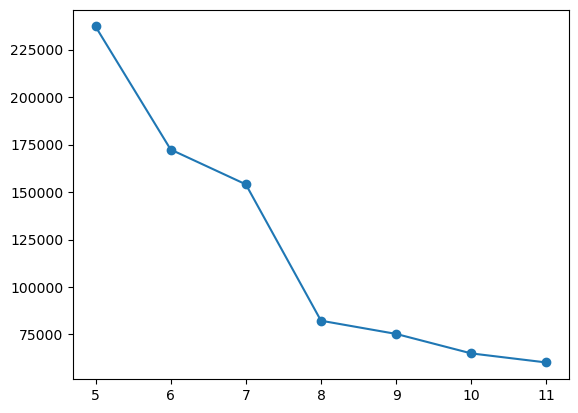

In [9]:
from sklearn.cluster import KMeans

inertia_values = []
possible_k_values = list(range(5, 12))
for k_val in tqdm(possible_k_values):
    kmeans = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
    kmeans.fit(flattened_prototypes)
    inertia_values.append(kmeans.inertia_)
plt.plot(possible_k_values, inertia_values, marker='o')
plt.show()

In [10]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(flattened_prototypes)
labels = kmeans.labels_
labels[:30], labels[30:]

(array([0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2,
        0, 3, 0, 0, 0, 3, 0, 2], dtype=int32),
 array([1, 4, 1, 4, 3, 3, 5, 3, 4, 3, 1, 1, 1, 5, 4, 3, 1, 1, 3, 1, 3, 7,
        1, 5, 4, 3, 1, 7, 3, 1], dtype=int32))

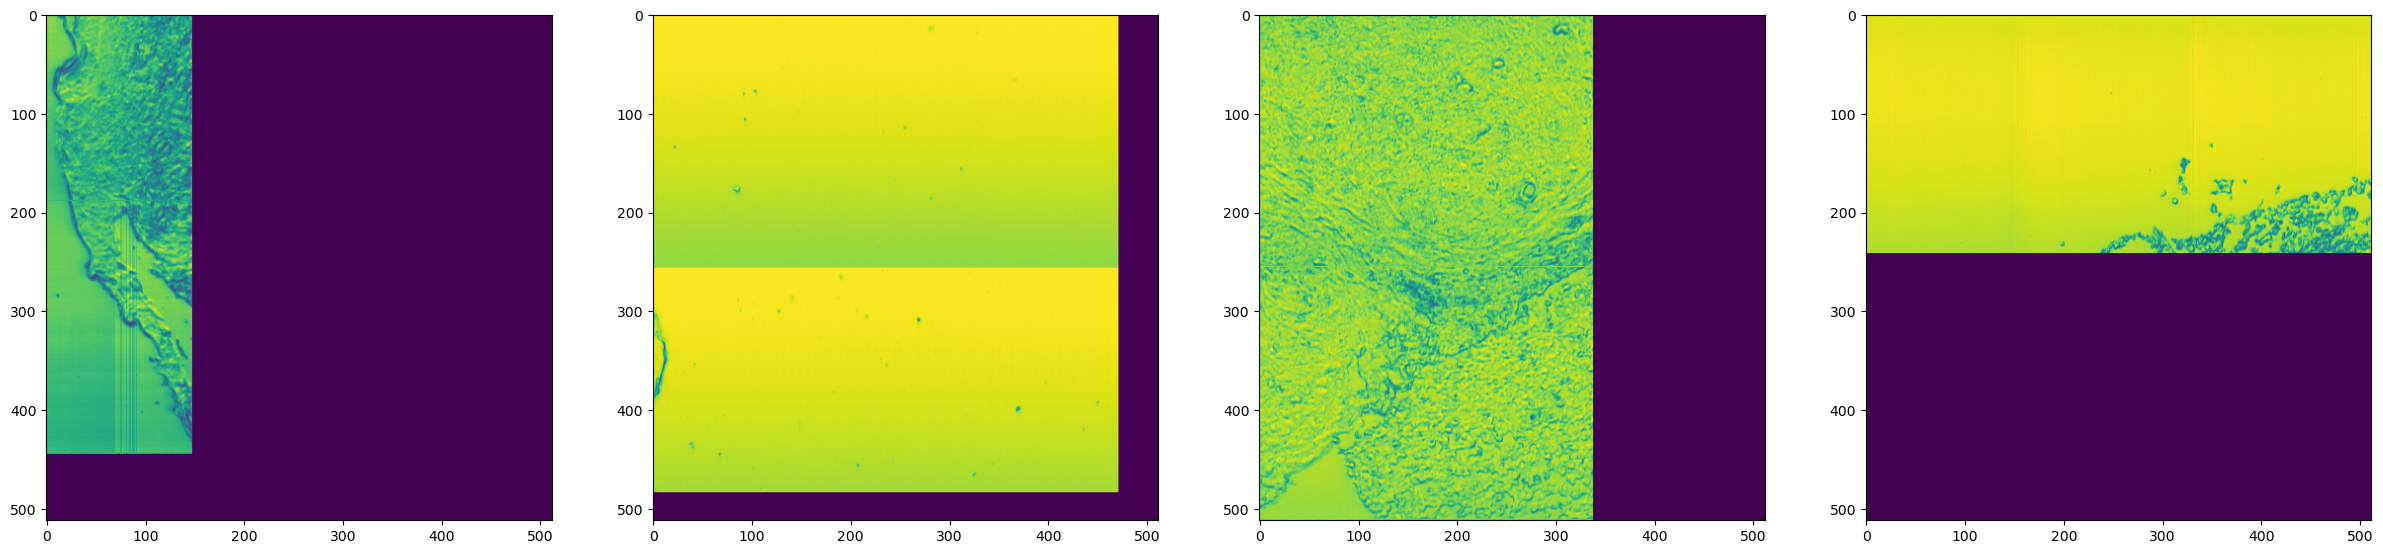

In [11]:
# plot side by side
fig, axes = plt.subplots(1, 4, figsize=(30, 20))
axes[0].imshow(prototypes[0, :, :, 21])
axes[1].imshow(prototypes[3, :, :, 21])
axes[2].imshow(prototypes[13, :, :, 21])
axes[3].imshow(prototypes[27, :, :, 21])

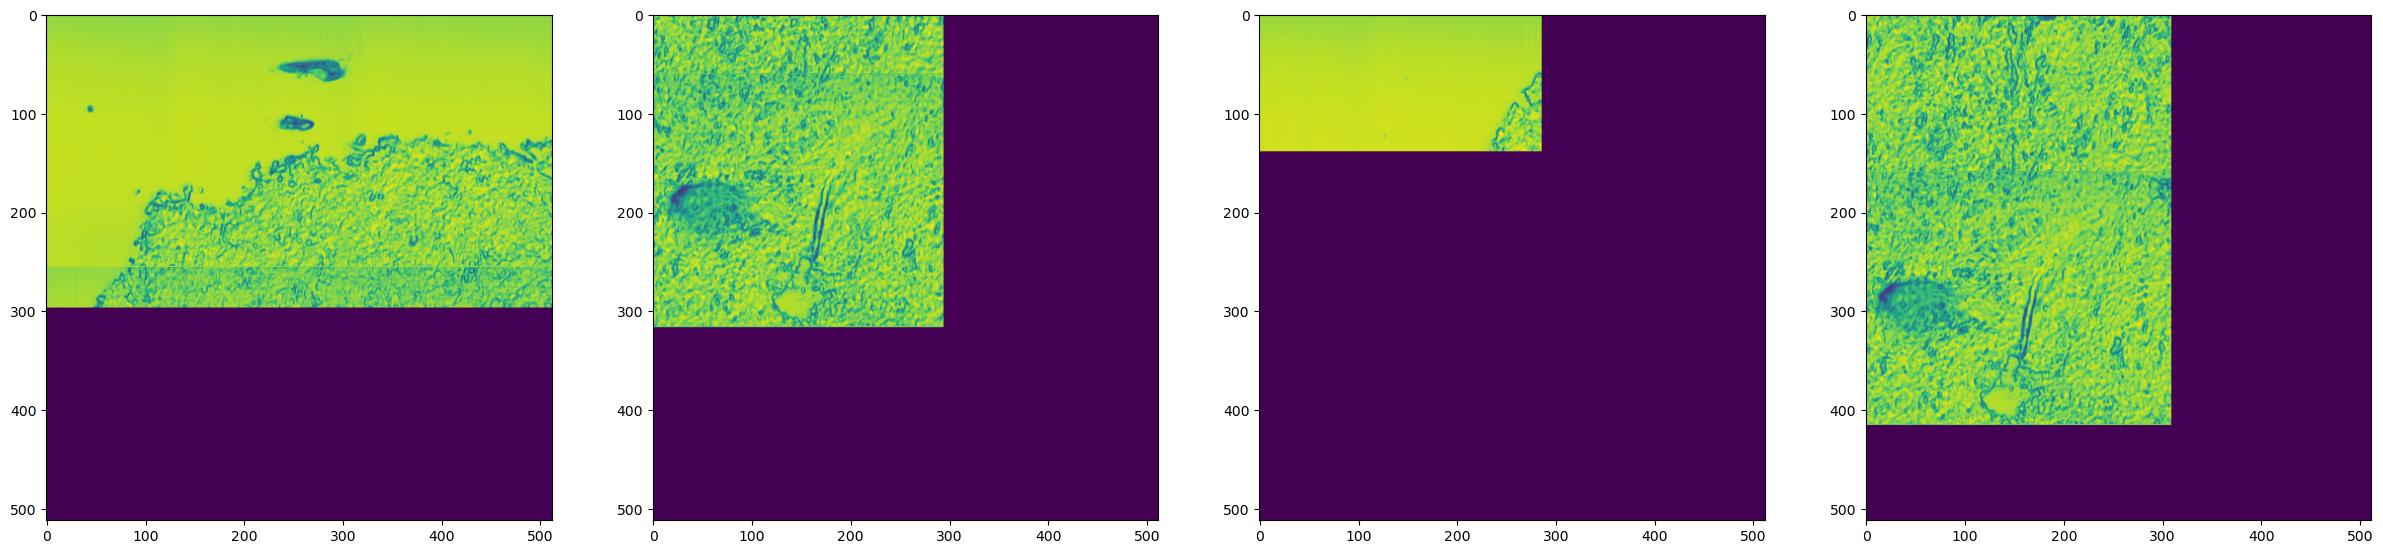

In [12]:
# plot side by side
fig, axes = plt.subplots(1, 4, figsize=(30, 20))
axes[0].imshow(prototypes[30, :, :, 21])
axes[1].imshow(prototypes[31, :, :, 21])
axes[2].imshow(prototypes[36, :, :, 21])
axes[3].imshow(prototypes[51, :, :, 21])

In [13]:
interesting_prototypes_i = [0, 3, 13, 27, 30, 31, 36, 51]
interesting_prototypes = [prototypes[i] for i in interesting_prototypes_i]

In [14]:
@dataclass
class BoundingBox:
    index: int
    bounds: list[int]

In [15]:
bounding_box_data = []
with open(os.path.join(PROTOTYPE_PATH, "prototype_bounds.txt"), 'r') as f:
    for s in f:
        index_match = re.search(r'index=(\d+)', s)
        index = int(index_match.group(1)) if index_match else None

        # Extract bounds
        bounds_match = re.search(r'bounds=\[([^\]]+)\]', s)
        bounds = list(map(int, bounds_match.group(1).split(','))) if bounds_match else None
        bounding_box = BoundingBox(index=index, bounds=bounds)
        bounding_box_data.append(bounding_box)

In [16]:
config_file = "./configs/unet_segment_newdata.yaml"
with open(config_file, "r") as stream:
    conf = yaml.safe_load(stream)

In [17]:
def patchify(big_img, conf):
    # h, w, c = big_img.shape
    ph, pw = conf['training']['patch_size']
    sh, sw = conf['training']['stride']
    tmp_img = big_img.unfold(0, ph, sh).unfold(1, pw, sw)  # N1, N2, C, H, W
    tmp_img = tmp_img.reshape(
        tmp_img.shape[0] * tmp_img.shape[1], tmp_img.shape[2], ph, pw
    )
    return tmp_img

In [18]:
def expected_patchify_shape(big_img_shape, conf):
    h, w, c = big_img_shape
    ph, pw = conf['training']['patch_size']
    sh, sw = conf['training']['stride']
    # Calculate the number of patches along the height (N1)
    # N1 = floor((H - ph) / sh) + 1
    n1 = math.floor((h - ph) / sh) + 1
    # Calculate the number of patches along the width (N2)
    # N2 = floor((W - pw) / sw) + 1
    n2 = math.floor((w - pw) / sw) + 1
    # The final shape after reshape is (N1 * N2, C, ph, pw)
    num_patches = n1 * n2
    return (num_patches, c, ph, pw)

In [19]:
train_ids = conf['data']['train_ids']

In [20]:
def load_filtered_patches_raman(raman_id, conf):
    patient_id = raman_id.split('_')[0]
    raman_ref = np.load(f"/home/ct678/code/charm_data/{patient_id}/{raman_id}_SRS_corrected.npy", mmap_mode='r')
    patched_raman = patchify(torch.from_numpy(raman_ref), conf)
    # filter out background patches
    all_zero = torch.all(patched_raman == 0, dim=(1, 2, 3))
    ids_to_include = torch.where(~all_zero)[0]
    patched_raman = patched_raman[ids_to_include]
    return patched_raman, ids_to_include

In [21]:
def locate_sample_and_index(train_ids, bounding_box_index):
    current_index_start = 0
    for train_id in tqdm(train_ids):
        patched_raman, ids_to_include = load_filtered_patches_raman(train_id, conf)
        next_index_start = current_index_start + patched_raman.shape[0]
        if current_index_start <= bounding_box_index < next_index_start:
            located_sample = train_id
            index_within_sample = bounding_box_index - current_index_start
            return located_sample, index_within_sample, ids_to_include
        current_index_start = next_index_start
    raise ValueError(f"Bounding box index {bounding_box_index} not found in train IDs.")

In [22]:
def get_hne_bound(located_sample, index_within_sample, ids_to_include, bounding_box_bounds):
    hne_located = np.load(os.path.join(f"{HNE_PATH}", f"{located_sample}_align_hne.npy"), mmap_mode='r')
    hne_downsized = cv2.resize(hne_located, (hne_located.shape[1] // 2, hne_located.shape[0] // 2), interpolation=cv2.INTER_LINEAR)
    patched_hne = patchify(torch.from_numpy(hne_downsized), conf)
    patched_hne = patched_hne[ids_to_include]

    selected_patch = patched_hne[index_within_sample]
    selected_bound = selected_patch[:, bounding_box_bounds[0]:bounding_box_bounds[1], bounding_box_bounds[2]:bounding_box_bounds[3]]
    return selected_bound.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization

In [32]:
def get_mask_bound(located_sample, index_within_sample, ids_to_include, bounding_box_bounds):
    mask_path = np.load(os.path.join(f"{MASK_PATH}", f"{located_sample}.npy"), mmap_mode='r')
    mask_downsized = cv2.resize(mask_path, (mask_path.shape[1] // 2, mask_path.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    mask_downsized = np.expand_dims(mask_downsized, axis=-1)  # Add channel dimension
    patched_mask = patchify(torch.from_numpy(mask_downsized), conf)
    patched_mask = patched_mask[ids_to_include]

    selected_patch = patched_mask[index_within_sample]
    selected_bound = selected_patch[:, bounding_box_bounds[0]:bounding_box_bounds[1], bounding_box_bounds[2]:bounding_box_bounds[3]]
    return selected_bound.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization

In [24]:
bounding_boxes_to_check = [bounding_box_data[i] for i in interesting_prototypes_i]
len(bounding_boxes_to_check)

8

 84%|████████▍ | 16/19 [01:15<00:14,  4.75s/it]


(array([ 0, 13], dtype=uint8), array([37515, 28345]))


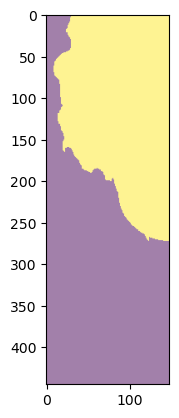

 21%|██        | 4/19 [00:28<01:45,  7.04s/it]


(array([0], dtype=uint8), array([227964]))


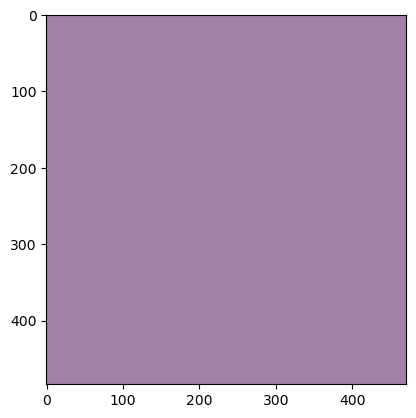

 11%|█         | 2/19 [00:16<02:22,  8.38s/it]


(array([0, 1], dtype=uint8), array([82556, 90500]))


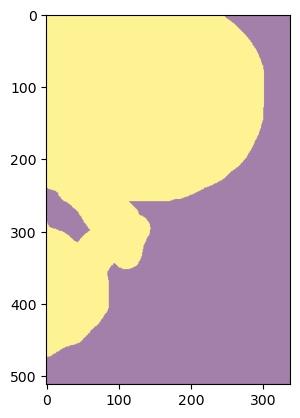

  5%|▌         | 1/19 [00:12<03:36, 12.03s/it]


(array([0], dtype=uint8), array([123904]))


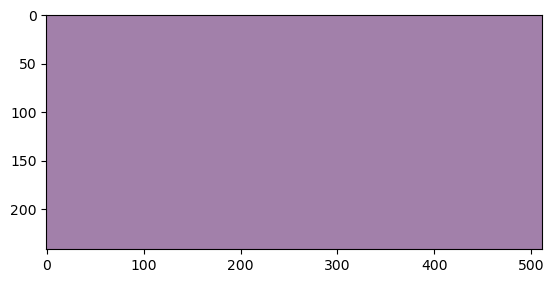

 53%|█████▎    | 10/19 [00:55<00:50,  5.57s/it]


(array([0, 1], dtype=uint8), array([95681, 56383]))


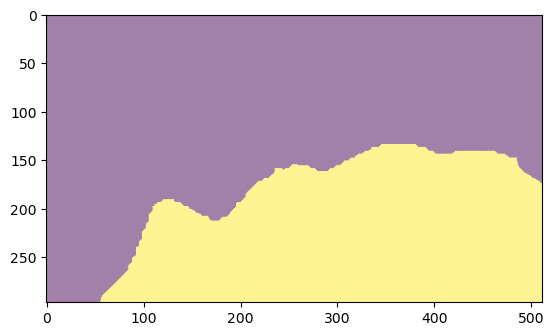

 53%|█████▎    | 10/19 [00:54<00:48,  5.43s/it]


(array([0, 1], dtype=uint8), array([ 9373, 83825]))


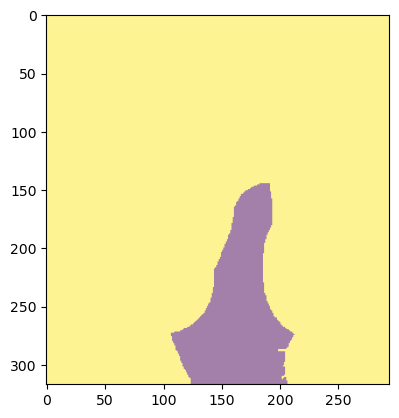

 53%|█████▎    | 10/19 [00:53<00:48,  5.35s/it]


(array([0, 1], dtype=uint8), array([39122,   632]))


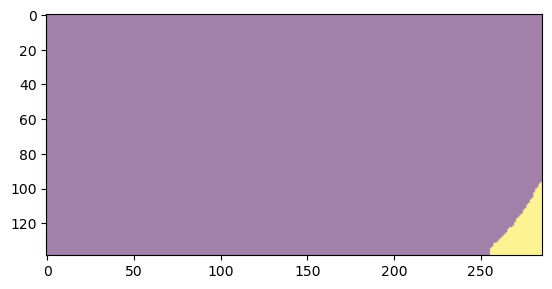

 53%|█████▎    | 10/19 [00:53<00:48,  5.35s/it]


(array([0, 1], dtype=uint8), array([  9373, 119171]))


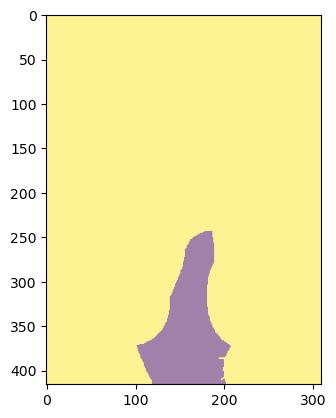

In [ ]:
for bounding_box in bounding_boxes_to_check:
    bounding_box_index = bounding_box.index
    bounds = bounding_box.bounds
    located_sample, index_within_sample, ids_to_include = locate_sample_and_index(train_ids, bounding_box_index)
    mask_bound = get_mask_bound(located_sample, index_within_sample, ids_to_include, bounds)
    print(np.unique(mask_bound, return_counts=True))
    hne_bound = get_hne_bound(located_sample, index_within_sample, ids_to_include, bounds)
    plt.imshow(hne_bound)
    plt.imshow(mask_bound, alpha=0.5)
    plt.show()